In [31]:
import pandas as pd

# Load your datasets
data_23rd = pd.read_csv(r'C:/Users/aidan/codeprojects/ML/ArduinoWineSniffer/src/data_analysis_for_NN/cleaned_data23rd.csv')
data_30th = pd.read_csv(r'C:/Users/aidan/codeprojects/ML/ArduinoWineSniffer/src/data_analysis_for_NN/cleaned_data30th.csv')

# Drop unnecessary timestamp column
data_23rd.drop(columns=['yyyy-mm-dd timestamp'], inplace=True)
data_30th.drop(columns=['yyyy-mm-dd timestamp'], inplace=True)

# Add a 'Day' column to distinguish between datasets
data_23rd['Day'] = '23rd'
data_30th['Day'] = '30th'

# Combine datasets for processing
combined_data = pd.concat([data_23rd, data_30th], ignore_index=True)

# Filter for specific wine labels in the Target column
wine_labels = ["TallHorse", "Namaqua", "Sophie", "Moscato", "BlackTie", "SilverMyn"]
filtered_data = combined_data[combined_data['Target'].str.contains('|'.join(wine_labels))]

# Separate features and target labels
features = filtered_data.drop(columns=['Target', 'Day'])
target_labels = filtered_data['Target']
day_labels = filtered_data['Day']


In [32]:
from sklearn.preprocessing import StandardScaler

# Standardize the features (mean=0, variance=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Create a new DataFrame with scaled features for further analysis
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)
scaled_data['Target'] = target_labels
scaled_data['Day'] = day_labels

scaled_data.head()  # Check the scaled data


,MQ6,MQ5,MQ4,MQ7,MQ3,MQ8,MQ2,MQ135,MQ9,BMPTemperature,Pressure(Pa),DHTTemperature,Humidity,Target,Day
0,0.340147,0.326440,0.510462,0.937327,-4.433567,0.839629,5.678840,3.875448,1.045740,3.320620,1.199601,-1.219483,0.349004,BlackTie,23rd
1,0.330054,0.369619,0.510462,0.937327,-4.263904,0.839629,5.678840,3.847206,1.129828,3.359788,1.014497,-1.219483,0.349004,BlackTie,23rd
2,0.330054,0.412799,0.478683,0.885918,-4.603231,0.839629,5.678840,3.847206,1.045740,3.398956,0.913853,-1.219483,0.349004,BlackTie,23rd
3,0.309867,0.369619,0.542240,0.963032,-4.433567,0.839629,5.810965,3.875448,1.213917,3.398956,0.619745,-1.219483,0.349004,BlackTie,23rd
4,0.330054,0.369619,0.478683,0.885918,-4.433567,0.839629,5.678840,3.847206,1.045740,3.398956,0.553127,-1.219483,0.349004,BlackTie,23rd


In [36]:
from sklearn.linear_model import LinearRegression

# Separate environmental features and gas sensor data
env_features = filtered_data[["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]]
gas_sensors = filtered_data[["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]]

# Fit a linear regression model to predict sensor values based on environmental factors
reg_model = LinearRegression()
reg_model.fit(env_features, gas_sensors)

# Predict the sensor values using environmental features
predicted_sensors = reg_model.predict(env_features)

# Subtract predicted values from actual sensor readings to remove environmental influence
residual_sensors = gas_sensors - predicted_sensors

# Create a new DataFrame with residuals and target labels
residual_data = pd.DataFrame(residual_sensors, columns=gas_sensors.columns)
residual_data['Target'] = target_labels
residual_data['Day'] = day_labels

residual_data.head()  # Check the residual data


,MQ6,MQ5,MQ4,MQ7,MQ3,MQ8,MQ2,MQ135,MQ9,Target,Day
0,108.176663,7.493150,15.880180,16.129944,-12.760260,75.661820,61.798441,59.644881,-4.697129,BlackTie,23rd
1,101.202238,7.884492,14.992106,15.259455,-11.611910,73.898103,61.426829,60.993506,-2.923671,BlackTie,23rd
2,98.016661,8.499462,13.436380,12.572896,-13.471425,73.038239,61.106948,61.958040,-3.567101,BlackTie,23rd
3,86.305174,6.720730,14.279059,14.932410,-12.444038,69.890790,62.926806,67.777802,-0.115391,BlackTie,23rd
4,86.105452,6.544342,12.016917,11.787335,-12.437834,69.177871,60.886002,67.869513,-1.786568,BlackTie,23rd


In [27]:
import torch
import torch.nn as nn

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(13, 8),
            nn.ReLU(),
            nn.Linear(8, 3)  # Reduce to 3-dimensional latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 8),
            nn.ReLU(),
            nn.Linear(8, 13)  # Reconstruct original feature set
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Prepare data for training (convert to torch tensors)
features_tensor = torch.tensor(scaled_features, dtype=torch.float32)

# Training loop
for epoch in range(100):  # Example number of epochs
    optimizer.zero_grad()
    outputs = model(features_tensor)
    loss = criterion(outputs, features_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# After training, extract the encoded features
with torch.no_grad():
    encoded_features = model.encoder(features_tensor).numpy()

# Create a DataFrame with the encoded features
encoded_data = pd.DataFrame(encoded_features, columns=['Latent1', 'Latent2', 'Latent3'])
encoded_data['Target'] = target_labels
encoded_data['Day'] = day_labels

encoded_data.head()  # Check the encoded features


Epoch 0, Loss: 1.0495800971984863
Epoch 10, Loss: 1.0272074937820435
Epoch 20, Loss: 1.0093036890029907
Epoch 30, Loss: 0.9928930401802063
Epoch 40, Loss: 0.9747068285942078
Epoch 50, Loss: 0.953523576259613
Epoch 60, Loss: 0.9279383420944214
Epoch 70, Loss: 0.8975426554679871
Epoch 80, Loss: 0.8632144331932068
Epoch 90, Loss: 0.8271591663360596


,Latent1,Latent2,Latent3,Target,Day
0,0.123720,0.500623,-2.981549,BlackTie,23rd
1,0.135877,0.501115,-2.986837,BlackTie,23rd
2,0.090012,0.467404,-2.982333,BlackTie,23rd
3,0.107877,0.469976,-3.010742,BlackTie,23rd
4,0.064717,0.430512,-2.942872,BlackTie,23rd


In [34]:
from sklearn.cluster import KMeans

# Perform K-means clustering on the scaled features
kmeans = KMeans(n_clusters=len(wine_labels), random_state=42)
kmeans.fit(scaled_features)

# Add the cluster labels to the DataFrame
scaled_data['Cluster'] = kmeans.labels_

# Visualize the clustering results
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x='MQ6', y='MQ7', hue='Cluster', style='Day', data=scaled_data, palette='Set1')
plt.title('K-Means Clustering of Wine Data')
plt.show()


ValueError: Could not interpret value `Cluster` for `hue`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

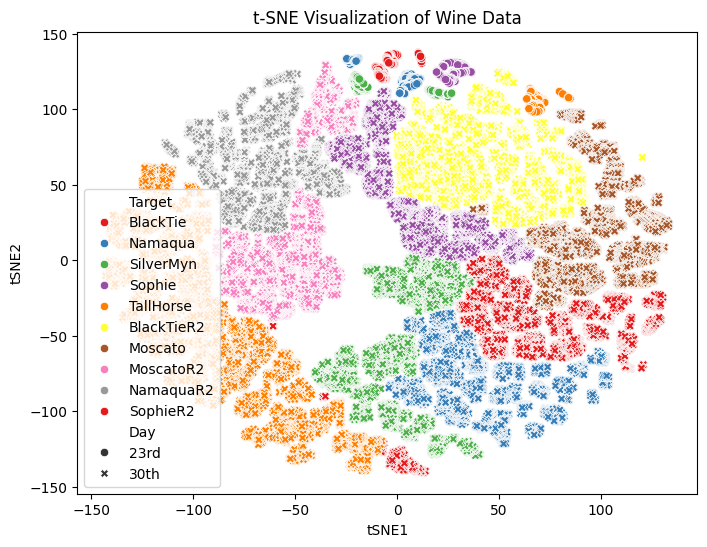

In [29]:
from sklearn.manifold import TSNE

# Perform t-SNE on the scaled features
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_features)

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_result, columns=['tSNE1', 'tSNE2'])
tsne_df['Target'] = target_labels
tsne_df['Day'] = day_labels

# Plot the t-SNE result
plt.figure(figsize=(8, 6))
sns.scatterplot(x='tSNE1', y='tSNE2', hue='Target', style='Day', data=tsne_df, palette='Set1')
plt.title('t-SNE Visualization of Wine Data')
plt.show()


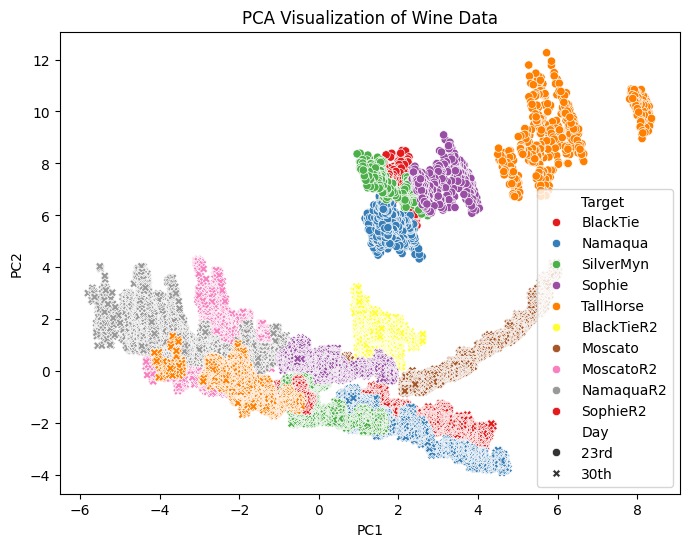

In [30]:
from sklearn.decomposition import PCA

# Perform PCA on scaled features
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Target'] = target_labels
pca_df['Day'] = day_labels

# Plot the PCA result
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Target', style='Day', data=pca_df, palette='Set1')
plt.title('PCA Visualization of Wine Data')
plt.show()


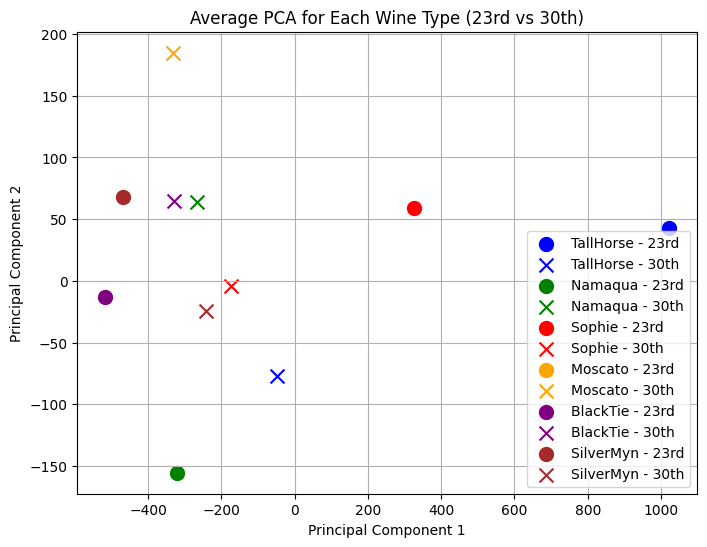

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Define wine labels
wine_labels = ["TallHorse", "Namaqua", "Sophie", "Moscato", "BlackTie", "SilverMyn"]

# Define color map for the wines
color_map = {
    "TallHorse": 'blue',
    "Namaqua": 'green',
    "Sophie": 'red',
    "Moscato": 'orange',
    "BlackTie": 'purple',
    "SilverMyn": 'brown'
}

# Define marker styles for different days
marker_map = {
    '23rd': 'o',  # Circle for 23rd
    '30th': 'x'   # X for 30th
}

# Function to process each dataset, perform PCA, and calculate average PCA values
def process_data_for_pca(data, day_label):
    # Filter for specific wine names in the Target column
    filtered_data = data[data['Target'].str.contains('|'.join(wine_labels))]

    # Separate features (MQ and environmental data) from the Target and Day columns
    features = filtered_data.drop(columns=['Target', 'Day'])
    target_labels = filtered_data['Target']

    # Perform PCA with 2 components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    pca_df['Target'] = target_labels
    pca_df['Day'] = day_label  # Add the day label

    # Ensure the PCA components are numeric before applying mean
    pca_df[['PC1', 'PC2']] = pca_df[['PC1', 'PC2']].apply(pd.to_numeric)

    # Group by wine type and calculate the average of the PCA components
    mean_pca = pca_df.groupby('Target', as_index=False)[['PC1', 'PC2']].mean()
    
    return mean_pca

# Perform PCA on both datasets
mean_pca_23rd = process_data_for_pca(data_23rd, '23rd')
mean_pca_30th = process_data_for_pca(data_30th, '30th')

# Combine both datasets for plotting
combined_mean_pca = pd.concat([mean_pca_23rd, mean_pca_30th])

# Plotting the average PCA values for each wine type from both datasets
plt.figure(figsize=(8, 6))

# Scatter plot for both days with different markers but same colors for the same wine
for wine in wine_labels:
    # Plot data for 23rd
    avg_pca_values_23rd = mean_pca_23rd[mean_pca_23rd['Target'] == wine]
    plt.scatter(
        avg_pca_values_23rd['PC1'], avg_pca_values_23rd['PC2'], 
        label=f'{wine} - 23rd', color=color_map[wine], marker=marker_map['23rd'], s=100
    )

    # Plot data for 30th
    avg_pca_values_30th = mean_pca_30th[mean_pca_30th['Target'] == wine]
    plt.scatter(
        avg_pca_values_30th['PC1'], avg_pca_values_30th['PC2'], 
        label=f'{wine} - 30th', color=color_map[wine], marker=marker_map['30th'], s=100
    )

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Average PCA for Each Wine Type (23rd vs 30th)')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()


In [38]:
# Function to fit a linear regression model and obtain residuals
def calculate_residuals(data):
    # Filter for specific wine names in the Target column
    filtered_data = data[data['Target'].str.contains('|'.join(wine_labels))]

    # Separate environmental features and gas sensor data
    env_features = filtered_data[["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]]
    gas_sensors = filtered_data[["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]]

    # Fit a linear regression model to predict sensor values based on environmental factors
    reg_model = LinearRegression()
    reg_model.fit(env_features, gas_sensors)

    # Predict the sensor values using environmental features
    predicted_sensors = reg_model.predict(env_features)

    # Subtract predicted values from actual sensor readings to remove environmental influence
    residual_sensors = gas_sensors - predicted_sensors

    # Create a new DataFrame with residuals and target labels
    residual_data = pd.DataFrame(residual_sensors, columns=gas_sensors.columns)
    residual_data['Target'] = filtered_data['Target'].values
    residual_data['Day'] = filtered_data['Day'].values
    
    return residual_data

# Calculate residuals for both datasets
residual_data_23rd = calculate_residuals(data_23rd)
residual_data_30th = calculate_residuals(data_30th)


In [39]:

# Function to process residual data, perform PCA, and calculate average PCA values
def process_data_for_pca(residual_data, day_label):
    # Separate features from the Target and Day columns
    features = residual_data.drop(columns=['Target', 'Day'])
    target_labels = residual_data['Target']

    # Perform PCA with 2 components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    pca_df['Target'] = target_labels
    pca_df['Day'] = day_label  # Add the day label

    # Group by wine type and calculate the average of the PCA components
    mean_pca = pca_df.groupby('Target', as_index=False)[['PC1', 'PC2']].mean()
    
    return mean_pca

# Perform PCA on both datasets
mean_pca_23rd = process_data_for_pca(residual_data_23rd, '23rd')
mean_pca_30th = process_data_for_pca(residual_data_30th, '30th')


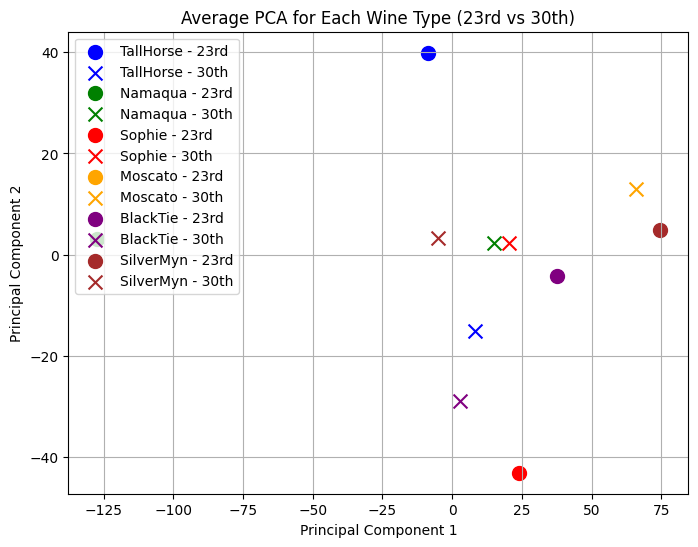

In [40]:
# Define color map for the wines
color_map = {
    "TallHorse": 'blue',
    "Namaqua": 'green',
    "Sophie": 'red',
    "Moscato": 'orange',
    "BlackTie": 'purple',
    "SilverMyn": 'brown'
}

# Define marker styles for different days
marker_map = {
    '23rd': 'o',  # Circle for 23rd
    '30th': 'x'   # X for 30th
}

# Combine both datasets for plotting
combined_mean_pca = pd.concat([mean_pca_23rd, mean_pca_30th])

# Plotting the average PCA values for each wine type from both datasets
plt.figure(figsize=(8, 6))

# Scatter plot for both days with different markers but same colors for the same wine
for wine in wine_labels:
    # Plot data for 23rd
    avg_pca_values_23rd = mean_pca_23rd[mean_pca_23rd['Target'] == wine]
    plt.scatter(
        avg_pca_values_23rd['PC1'], avg_pca_values_23rd['PC2'], 
        label=f'{wine} - 23rd', color=color_map[wine], marker=marker_map['23rd'], s=100
    )

    # Plot data for 30th
    avg_pca_values_30th = mean_pca_30th[mean_pca_30th['Target'] == wine]
    plt.scatter(
        avg_pca_values_30th['PC1'], avg_pca_values_30th['PC2'], 
        label=f'{wine} - 30th', color=color_map[wine], marker=marker_map['30th'], s=100
    )

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Average PCA for Each Wine Type (23rd vs 30th)')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()


In [46]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features (environmental) and target (MQ sensor residuals)
X = combined_data[["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]].values
y = combined_data[["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 64)  # Input layer
        self.fc2 = nn.Linear(64, 64)  # Hidden layer
        self.fc3 = nn.Linear(64, 9)   # Output layer (MQ sensor outputs)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function
        x = torch.relu(self.fc2(x))  # Activation function
        x = self.fc3(x)               # Output layer
        return x

# Instantiate the model, define the loss function and the optimizer
model = NeuralNetwork()
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluating the model
model.eval()
with torch.no_grad():
    predicted_sensors = model(X_test_tensor)

# Calculate residuals
residuals = predicted_sensors.numpy() - y_test_tensor.numpy()

# Calculate distances between predicted and actual
distances = np.linalg.norm(residuals, axis=1)

# Calculate maximum distances for normalization
max_distances = np.linalg.norm(y_test_tensor.numpy(), axis=1)

# Calculate total distance over max distance for all wines
total_distance = np.sum(distances)
total_max_distance = np.sum(max_distances)

error_ratio = total_distance / total_max_distance if total_max_distance > 0 else 0

print(f'Total Distance: {total_distance:.4f}')
print(f'Total Max Distance: {total_max_distance:.4f}')
print(f'Error Ratio (Total Distance / Total Max Distance): {error_ratio:.4f}')


Epoch [10/100], Loss: 454494.4062
Epoch [20/100], Loss: 454099.1875
Epoch [30/100], Loss: 453693.5625
Epoch [40/100], Loss: 453253.1250
Epoch [50/100], Loss: 452772.5312
Epoch [60/100], Loss: 452247.2812
Epoch [70/100], Loss: 451679.7188
Epoch [80/100], Loss: 451070.5938
Epoch [90/100], Loss: 450420.0625
Epoch [100/100], Loss: 449725.6562
Total Distance: 52939380.0000
Total Max Distance: 53224828.0000
Error Ratio (Total Distance / Total Max Distance): 0.9946


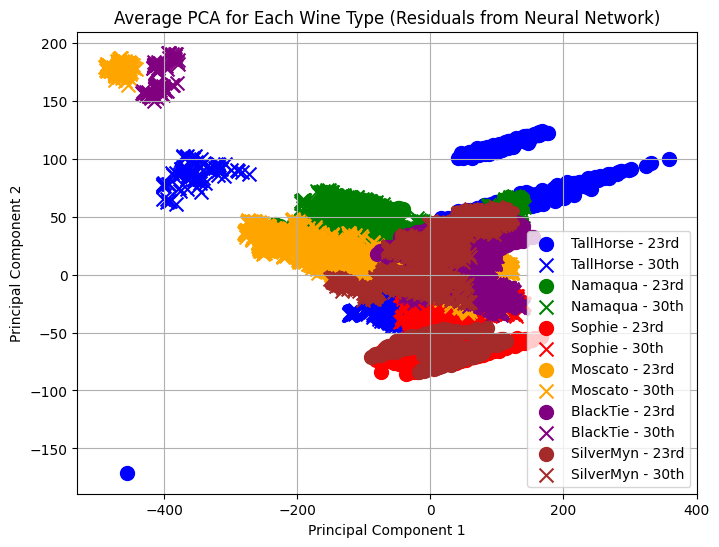

In [44]:
# Assuming you have the following imports and previous steps:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Define wine labels and color map as before
wine_labels = ["TallHorse", "Namaqua", "Sophie", "Moscato", "BlackTie", "SilverMyn"]
color_map = {
    "TallHorse": 'blue',
    "Namaqua": 'green',
    "Sophie": 'red',
    "Moscato": 'orange',
    "BlackTie": 'purple',
    "SilverMyn": 'brown'
}

# Define marker styles for different days
marker_map = {
    '23rd': 'o',  # Circle for 23rd
    '30th': 'x'   # X for 30th
}

# Function to perform PCA on residual data
def perform_pca_on_residuals(data, day_label):
    # Filter for specific wine names in the Target column
    filtered_data = data[data['Target'].str.contains('|'.join(wine_labels))]
    
    # Separate features (residuals) from the Target and Day columns
    features = filtered_data.drop(columns=['Target', 'Day'])
    target_labels = filtered_data['Target']

    # Perform PCA with 2 components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    pca_df['Target'] = target_labels
    pca_df['Day'] = day_label  # Add the day label

    return pca_df

# Perform PCA on the residuals for both datasets
pca_residuals_23rd = perform_pca_on_residuals(residual_data[residual_data['Day'] == '23rd'], '23rd')
pca_residuals_30th = perform_pca_on_residuals(residual_data[residual_data['Day'] == '30th'], '30th')

# Combine both datasets for plotting
combined_pca_residuals = pd.concat([pca_residuals_23rd, pca_residuals_30th])

# Plotting the average PCA values for each wine type from both datasets
plt.figure(figsize=(8, 6))

# Scatter plot for both days with different markers but same colors for the same wine
for wine in wine_labels:
    # Plot data for 23rd
    avg_pca_values_23rd = pca_residuals_23rd[pca_residuals_23rd['Target'] == wine]
    plt.scatter(
        avg_pca_values_23rd['PC1'], avg_pca_values_23rd['PC2'], 
        label=f'{wine} - 23rd', color=color_map[wine], marker=marker_map['23rd'], s=100
    )

    # Plot data for 30th
    avg_pca_values_30th = pca_residuals_30th[pca_residuals_30th['Target'] == wine]
    plt.scatter(
        avg_pca_values_30th['PC1'], avg_pca_values_30th['PC2'], 
        label=f'{wine} - 30th', color=color_map[wine], marker=marker_map['30th'], s=100
    )

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Average PCA for Each Wine Type (Residuals from Neural Network)')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()


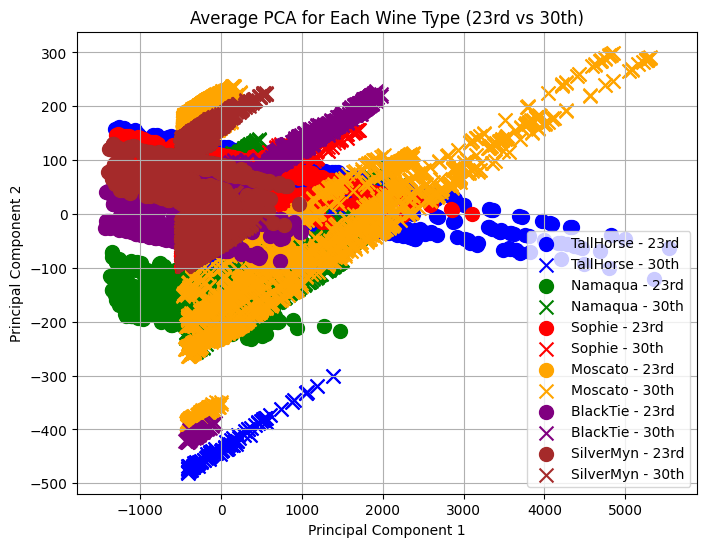

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming combined_data is your original DataFrame containing the necessary data

# Define the color map for the wines
color_map = {
    "TallHorse": 'blue',
    "Namaqua": 'green',
    "Sophie": 'red',
    "Moscato": 'orange',
    "BlackTie": 'purple',
    "SilverMyn": 'brown'
}

# Define marker styles for different days
marker_map = {
    '23rd': 'o',  # Circle for 23rd
    '30th': 'x'   # X for 30th
}

# Function to perform PCA on given data for a specific day
def perform_pca(data, day_label):
    # Filter data for the specific day
    filtered_data = data[data['Day'] == day_label]
    features = filtered_data.drop(columns=['Target', 'Day'])
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    pca_df['Target'] = filtered_data['Target']
    pca_df['Day'] = day_label  # Add the day label

    return pca_df

# Perform PCA on the combined data for both datasets
pca_23rd = perform_pca(combined_data, '23rd')
pca_30th = perform_pca(combined_data, '30th')

# Combine both datasets for plotting
combined_mean_pca = pd.concat([pca_23rd, pca_30th])

# Define wine labels for plotting
wine_labels = ["TallHorse", "Namaqua", "Sophie", "Moscato", "BlackTie", "SilverMyn"]

# Plotting the average PCA values for each wine type from both datasets
plt.figure(figsize=(8, 6))

# Scatter plot for both days with different markers but same colors for the same wine
for wine in wine_labels:
    # Plot data for 23rd
    avg_pca_values_23rd = pca_23rd[pca_23rd['Target'] == wine]
    plt.scatter(
        avg_pca_values_23rd['PC1'], avg_pca_values_23rd['PC2'], 
        label=f'{wine} - 23rd', color=color_map[wine], marker=marker_map['23rd'], s=100
    )

    # Plot data for 30th
    avg_pca_values_30th = pca_30th[pca_30th['Target'] == wine]
    plt.scatter(
        avg_pca_values_30th['PC1'], avg_pca_values_30th['PC2'], 
        label=f'{wine} - 30th', color=color_map[wine], marker=marker_map['30th'], s=100
    )

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Average PCA for Each Wine Type (23rd vs 30th)')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()
